In [2]:
# Imports

import os
import json
import tqdm
import yaml

import torch
import numpy as np
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from pathlib import Path
from tqdm.auto import tqdm

/home/denis/miniconda3/envs/dal-toolbox/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%%bash
fusermount -uz /mnt/work/dhuseljic
sshfs cluster.ies:/mnt/work/dhuseljic/ /mnt/work/dhuseljic

In [4]:
def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def verify_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'

    result_json = path / 'results.json'
    if not result_json.is_file():
        raise ValueError()

def load_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
        
    results = {}

    exp_json = path / 'results.json'
    exp_cfg = path / '.hydra' / 'config.yaml'

    if exp_cfg.is_file():
        cfg =  OmegaConf.load(exp_cfg)
        results['cfg'] = cfg
    else:
        raise ValueError(f'Config missing for {exp_cfg}')

    if exp_json.is_file():
        data = load_json(exp_json)
        results['results'] = data
    else:
        raise ValueError(f'Results missing for {exp_json}')

    return results

def get_experiments(result_path, glob_pattern, verify_only=False):
    # Aggregate results over multiple glob pattern such as seeds
    experiments = []
    print('Searching in', result_path)
    exp_paths = list(result_path.glob(glob_pattern))
    if len(exp_paths) < 1:
        raise ValueError(f'No experiments found in {result_path}')
    for exp_path in exp_paths:
        print('> Found', exp_path.name)
        if verify_only:
            verify_results(exp_path)
            continue
        d = load_results(exp_path)
        experiments.append(d)
    # assert len(experiments) != 0, f'No experiments found for {result_path}.'
    return experiments

path = f'/mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/random/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{18}/'
exp_results = get_experiments(Path(path), 'seed1', verify_only=True)
exp_results = get_experiments(Path(path), 'seed1')
print(exp_results[0]['results']['cycle0'].keys())
print(exp_results[0]['results']['cycle0']['test_stats'].keys())

Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/random/N_INIT128__ACQ_SIZE128__N_ACQ18
> Found seed1
Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18/random/N_INIT128__ACQ_SIZE128__N_ACQ18
> Found seed1
dict_keys(['test_stats', 'labeled_indices', 'n_labeled_samples', 'unlabeled_indices', 'n_unlabeled_samples'])
dict_keys(['accuracy', 'nll', 'brier', 'tce', 'ace'])


## Aleatoric Results

In [8]:
root_path = Path('/mnt/work/dhuseljic/results/udal/')
# root_path = Path('/home/denis/results/udal/')
verify_only = False
dataset = 'CIFAR100'
model = 'resnet18'
experiments = {}
n_init = 2048
acq_size = 2048
num_cycles = 9
# Deterministic
experiments.update({
    'random eval':  root_path / f'active_learning/{dataset}/resnet18/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'lc eval':      root_path / f'active_learning/{dataset}/resnet18/least_confident/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'margin eval':  root_path / f'active_learning/{dataset}/resnet18/margin/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy eval': root_path / f'active_learning/{dataset}/resnet18/entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})

# # Labels smoothing
experiments.update({
    # 'random (ls)':  root_path / f'active_learning/{dataset}/resnet18_labelsmoothing/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'lc (ls)':      root_path / f'active_learning/{dataset}/resnet18_labelsmoothing/least_confident/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'margin (ls)':  root_path / f'active_learning/{dataset}/resnet18_labelsmoothing/margin/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy (ls)': root_path / f'active_learning/{dataset}/resnet18_labelsmoothing/entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    # 'random (ls) eval':     root_path / f'evaluation/{dataset}/resnet18_labelsmoothing/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'lc (ls) eval':         root_path / f'evaluation/{dataset}/resnet18_labelsmoothing/least_confident/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'margin (ls) eval':     root_path / f'evaluation/{dataset}/resnet18_labelsmoothing/margin/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy (ls) eval':    root_path / f'evaluation/{dataset}/resnet18_labelsmoothing/entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})
# 
# Mixup
experiments.update({
    # 'random (mixup)':   root_path / f'active_learning/{dataset}/resnet18_mixup/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'lc (mixup)':       root_path / f'active_learning/{dataset}/resnet18_mixup/least_confident/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'margin (mixup)':   root_path / f'active_learning/{dataset}/resnet18_mixup/margin/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy (mixup)':  root_path / f'active_learning/{dataset}/resnet18_mixup/entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    # 'random (mixup) eval':  root_path / f'evaluation/{dataset}/resnet18_mixup/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'lc (mixup) eval':      root_path / f'evaluation/{dataset}/resnet18_mixup/least_confident/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'margin (mixup) eval':  root_path / f'evaluation/{dataset}/resnet18_mixup/margin/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy (mixup) eval': root_path / f'evaluation/{dataset}/resnet18_mixup/entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})


all_results = {}
for exp_name, exp_path in experiments.items():
    all_results[exp_name] = get_experiments(Path(exp_path), 'seed*', verify_only=verify_only)

Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR100/resnet18/random/N_INIT2048__ACQ_SIZE2048__N_ACQ9
> Found seed9
> Found seed3
> Found seed4
> Found seed10
> Found seed7
> Found seed5
> Found seed2
> Found seed8
> Found seed6
> Found seed1
Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR100/resnet18/margin/N_INIT2048__ACQ_SIZE2048__N_ACQ9
> Found seed10
> Found seed5
> Found seed2
> Found seed8
> Found seed6
> Found seed1
> Found seed9
> Found seed3
> Found seed4
> Found seed7


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 33.18it/s]


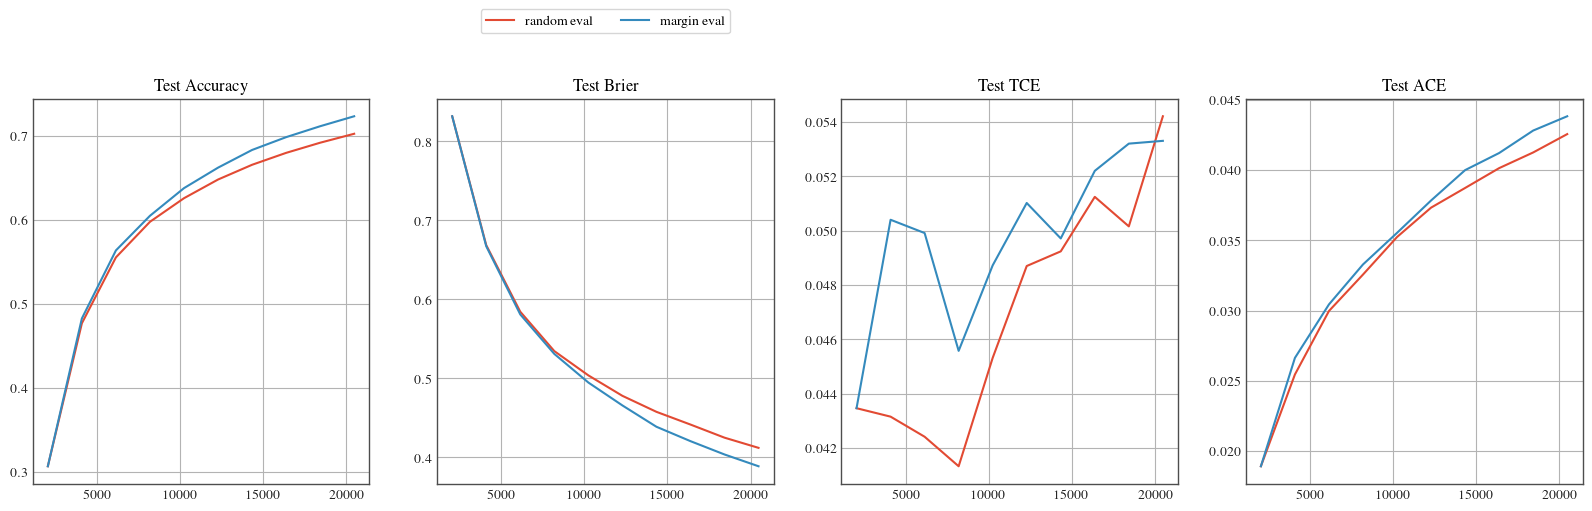

In [9]:
show_std = False
table_dict = {}
learning_curves = {}
plt.figure(figsize=(20, 5))
for strat_name, results in tqdm(all_results.items()):

    train_accs = []
    train_loss = []
    test_accs = []
    test_nll = []
    test_brier = []
    test_tce = []
    test_ace = []
    n_labeled_samples = []
    for seed_result in results:
        data = seed_result['results']
        # print(strat_name, data['cycle0']['labeled_indices'])

        # Get metric values of interest
        n_labeled_samples.append([data[cycle]['n_labeled_samples'] for cycle in data])
        # train_accs.append([data[cycle]['train_history'][-1]['train_acc1'] for cycle in data])
        # train_loss.append([data[cycle]['train_history'][-1]['train_loss'] for cycle in data])
        test_accs.append([data[cycle]['test_stats']['accuracy'] for cycle in data])
        test_nll.append([data[cycle]['test_stats']['nll'] for cycle in data])
        test_brier.append([data[cycle]['test_stats']['brier'] for cycle in data])
        test_tce.append([data[cycle]['test_stats']['tce'] for cycle in data])
        test_ace.append([data[cycle]['test_stats']['ace'] for cycle in data])

    n_labeled_samples = np.mean(n_labeled_samples, 0)
    # train_accs_mean, train_accs_std = np.mean(train_accs, 0), np.std(train_accs, 0)
    # train_loss_mean, train_loss_std = np.mean(train_loss, 0), np.std(train_loss, 0)
    test_accs_mean, test_accs_std = np.mean(test_accs, 0), np.std(test_accs, 0)
    test_nll_mean, test_nll_std = np.mean(test_nll, 0), np.std(test_nll, 0)
    test_brier_mean, test_brier_std = np.mean(test_brier, 0), np.std(test_brier, 0)
    test_tce_mean, test_tce_std = np.mean(test_tce, 0), np.std(test_tce, 0)
    test_ace_mean, test_ace_std = np.mean(test_ace, 0), np.std(test_ace, 0)

    learning_curves[strat_name] = {
        'acc': test_accs_mean, 'acc_std': test_accs_std,
        'nll': test_nll_mean, 'nll_std': test_nll_std,
        'brier': test_brier_mean, 'brier_std': test_brier_std,
        'tce': test_tce_mean, 'tce_std': test_tce_std,
        'ace': test_ace_mean, 'ace_std': test_ace_std,
    }

    table_dict[strat_name] = {
        'acc (Final)': test_accs_mean[-1], 
        'acc (AUC)': np.mean(test_accs_mean), 
        'nll (Final)': test_nll_mean[-1], 
        'nll (AUC)': np.mean(test_nll_mean), 
        'brier (Final)': test_brier_mean[-1], 
        'brier (AUC)': np.mean(test_brier_mean), 
        'TCE (Final)': test_tce_mean[-1],
        'TCE (AUC)': np.mean(test_tce_mean), 
        'ACE (Final)': test_ace_mean[-1],
        'ACE (AUC)': np.mean(test_ace_mean), 
    }

    plt.subplot(141)
    plt.title('Test Accuracy')
    plt.plot(n_labeled_samples, test_accs_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean+test_accs_std, alpha=.3)
    plt.subplot(142)
    plt.title('Test Brier')
    plt.plot(n_labeled_samples, test_brier_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_brier_mean-test_brier_std, test_brier_mean+test_brier_std, alpha=.3)
    plt.subplot(143)
    plt.title('Test TCE')
    plt.plot(n_labeled_samples, test_tce_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_tce_mean-test_tce_std, test_tce_mean+test_tce_std, alpha=.3)
    plt.subplot(144)
    plt.title('Test ACE')
    plt.plot(n_labeled_samples, test_ace_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_ace_mean-test_ace_std, test_ace_mean+test_ace_std, alpha=.3)

    # plt.subplot(141)
    # plt.title('NLL')
    # plt.plot(test_accs_mean, test_nll_mean)
    # plt.subplot(142)
    # plt.title('Brier')
    # plt.plot(test_accs_mean, test_brier_mean)
    # plt.subplot(143)
    # plt.title('TCE')
    # plt.plot(test_accs_mean, test_tce_mean)
    # plt.subplot(144)
    # plt.title('ACE')
    # plt.plot(test_accs_mean, test_ace_mean)


plt.subplot(142).legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=5)
        

In [8]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict).T
print(df.to_latex(float_format="%.3f"))
print(df.to_markdown(tablefmt='github'))

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & acc (Final) & acc (AUC) & nll (Final) & nll (AUC) & brier (Final) & brier (AUC) & TCE (Final) & TCE (AUC) & ACE (Final) & ACE (AUC) \\
\midrule
random eval & 0.702 & 0.582 & 1.197 & 1.758 & 0.413 & 0.549 & 0.053 & 0.052 & 0.043 & 0.034 \\
margin eval & 0.725 & 0.591 & 1.082 & 1.696 & 0.388 & 0.541 & 0.053 & 0.056 & 0.044 & 0.035 \\
\bottomrule
\end{tabular}

|             |   acc (Final) |   acc (AUC) |   nll (Final) |   nll (AUC) |   brier (Final) |   brier (AUC) |   TCE (Final) |   TCE (AUC) |   ACE (Final) |   ACE (AUC) |
|-------------|---------------|-------------|---------------|-------------|-----------------|---------------|---------------|-------------|---------------|-------------|
| random eval |       0.7021  |    0.581511 |       1.19695 |     1.75831 |        0.412951 |      0.548521 |     0.0533438 |   0.0518312 |     0.0427203 |   0.0339205 |
| margin eval |       0.72484 |    0.591052 |       1.08212 |     1.69614 |        0.387

In [18]:
print(df[['acc (Final)', 'acc (AUC)']].to_latex(float_format="%.3f"))

\begin{tabular}{lrr}
\toprule
 & acc (Final) & acc (AUC) \\
\midrule
random (ls) eval & 0.517 & 0.332 \\
lc (ls) eval & 0.508 & 0.303 \\
margin (ls) eval & 0.523 & 0.326 \\
entropy (ls) eval & 0.508 & 0.299 \\
random (mixup) eval & 0.522 & 0.334 \\
lc (mixup) eval & 0.497 & 0.286 \\
margin (mixup) eval & 0.516 & 0.315 \\
entropy (mixup) eval & 0.498 & 0.284 \\
\bottomrule
\end{tabular}



In [147]:
# df1 = df[['nll (AUC)', 'brier (AUC)', 'TCE (AUC)', 'ACE (AUC)']]
df1 = df[['nll (Final)', 'brier (Final)', 'TCE (Final)', 'ACE (Final)']]
print(df1.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrr}
\toprule
 & nll (Final) & brier (Final) & TCE (Final) & ACE (Final) \\
\midrule
random eval & 0.528 & 0.231 & 0.065 & 0.052 \\
margin eval & 0.441 & 0.196 & 0.052 & 0.046 \\
random (ls) & 0.537 & 0.227 & 0.043 & 0.030 \\
margin (ls) & 0.455 & 0.191 & 0.034 & 0.027 \\
random (ls) eval & 0.528 & 0.231 & 0.065 & 0.052 \\
margin (ls) eval & 0.435 & 0.194 & 0.051 & 0.046 \\
random (mixup) & 0.486 & 0.210 & 0.040 & 0.026 \\
margin (mixup) & 0.429 & 0.183 & 0.045 & 0.025 \\
random (mixup) eval & 0.527 & 0.230 & 0.064 & 0.052 \\
margin (mixup) eval & 0.453 & 0.202 & 0.055 & 0.048 \\
\bottomrule
\end{tabular}



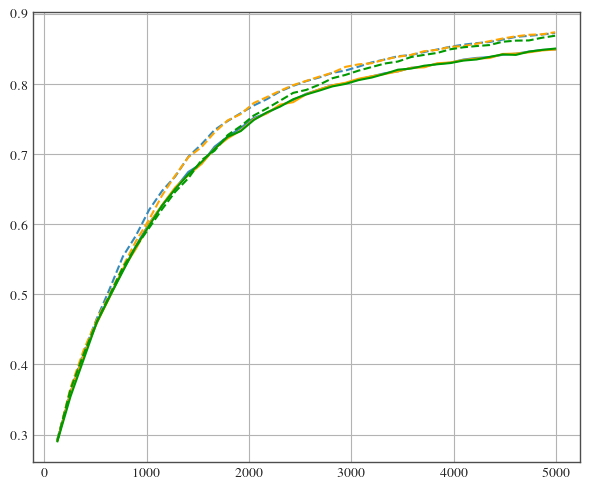

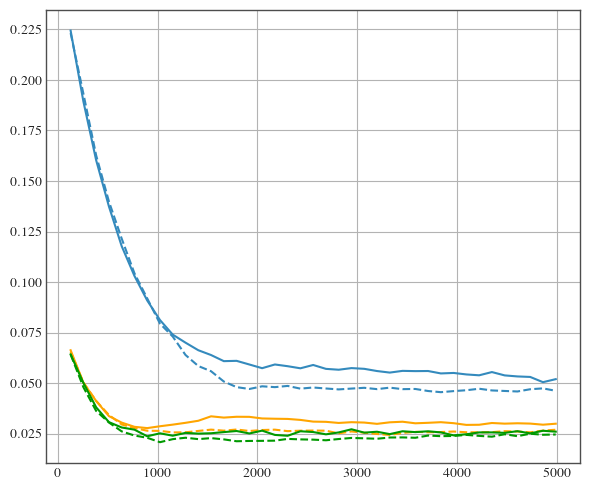

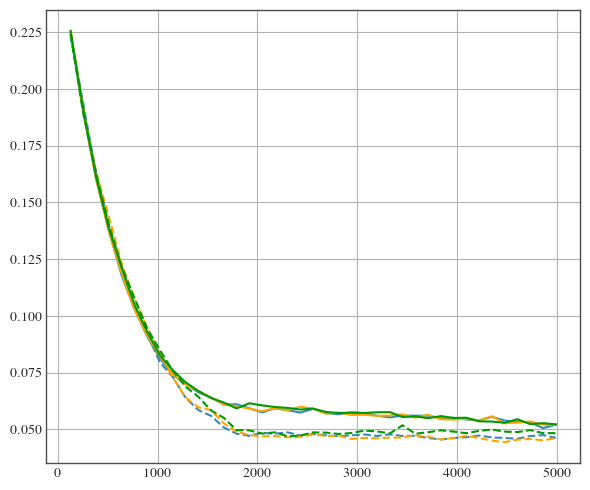

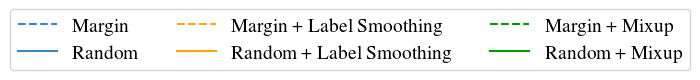

In [161]:
plt.figure(figsize=(6, 5))
plt.plot(n_labeled_samples, learning_curves['random eval']['acc'], '-', color='C1', label='random')
plt.plot(n_labeled_samples, learning_curves['margin eval']['acc'], '--', color='C1', label='margin')

plt.plot(n_labeled_samples, learning_curves['random (ls) eval']['acc'], '-', color='orange', label='random ls')
plt.plot(n_labeled_samples, learning_curves['margin (ls) eval']['acc'], '--', color='orange', label='margin ls')

plt.plot(n_labeled_samples, learning_curves['random (mixup) eval']['acc'], '-', color='C2', label='random mixup')
plt.plot(n_labeled_samples, learning_curves['margin (mixup) eval']['acc'], '--', color='C2', label='margin mixup')
plt.tight_layout()
plt.savefig('plots_al/evaluation_acc.pdf', bbox_inches='tight', pad_inches=0) 

plt.figure(figsize=(6, 5))
plt.plot(n_labeled_samples, learning_curves['random eval']['ace'], '-', color='C1', label='random')
plt.plot(n_labeled_samples, learning_curves['margin eval']['ace'], '--', color='C1', label='margin')

plt.plot(n_labeled_samples, learning_curves['random (ls)']['ace'], '-', color='orange', label='random ls')
plt.plot(n_labeled_samples, learning_curves['margin (ls)']['ace'], '--', color='orange', label='margin ls')

plt.plot(n_labeled_samples, learning_curves['random (mixup)']['ace'], '-', color='C2', label='random mixup')
plt.plot(n_labeled_samples, learning_curves['margin (mixup)']['ace'], '--', color='C2', label='margin mixup')
plt.tight_layout()
plt.savefig('plots_al/selection_ace.pdf', bbox_inches='tight', pad_inches=0) 

plt.figure(figsize=(6, 5))
plt.plot(n_labeled_samples, learning_curves['random eval']['ace'], '-', color='C1', label='random')
plt.plot(n_labeled_samples, learning_curves['margin eval']['ace'], '--', color='C1', label='margin')

plt.plot(n_labeled_samples, learning_curves['random (ls) eval']['ace'], '-', color='orange', label='random ls')
plt.plot(n_labeled_samples, learning_curves['margin (ls) eval']['ace'], '--', color='orange', label='margin ls')

plt.plot(n_labeled_samples, learning_curves['random (mixup) eval']['ace'], '-', color='C2', label='random mixup')
plt.plot(n_labeled_samples, learning_curves['margin (mixup) eval']['ace'], '--', color='C2', label='margin mixup')
plt.tight_layout()
plt.savefig('plots_al/evaluation_ace.pdf', bbox_inches='tight', pad_inches=0) 

colors = {
    'margin': 'C1',
    'margin_ls': 'orange',
    'margin_mixup': 'C2',
}

fig = plt.figure()
plt.plot([], [], '--', label='Margin', color=colors['margin'])
plt.plot([], [], '-', label='Random', color=colors['margin'])
plt.plot([], [], '--', label='Margin + Label Smoothing', color=colors['margin_ls'])
plt.plot([], [], '-', label='Random + Label Smoothing', color=colors['margin_ls'])
plt.plot([], [], '--', label='Margin + Mixup', color=colors['margin_mixup'])
plt.plot([], [], '-', label='Random + Mixup', color=colors['margin_mixup'])
plt.gca().set_visible(False)
fig.legend(loc='upper left', bbox_to_anchor = (0, .1, 1, 1), ncol=3,  prop=dict(size=14))
# cax = plt.axes([0.1, 1, .8, .02])
plt.tight_layout()
plt.savefig('plots_al/legend_exemplary_lc.pdf', bbox_inches='tight', pad_inches=0) 
plt.show()

## Epistemic Results

In [27]:
root_path = Path('/mnt/work/dhuseljic/results/udal/')
dataset = 'SVHN'
experiments = {}
n_init = 128
acq_size = 128
num_cycles = 19

# MC-Dropout
experiments.update({
    'random (MC-Dropout)': root_path / f'active_learning/{dataset}/resnet18_mcdropout/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'entropy (MC-Dropout)': root_path / f'active_learning/{dataset}/resnet18_mcdropout/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'bald (MC-Dropout)': root_path / f'active_learning/{dataset}/resnet18_mcdropout/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    'varratio (MC-Dropout)': root_path / f'active_learning/{dataset}/resnet18_mcdropout/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    # 'random eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'bald eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'varratio eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    # 'random eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout_sngp/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout_sngp/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'bald eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout_sngp/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'varratio eval (MC-Dropout)': root_path / f'evaluation/{dataset}/resnet18_mcdropout_sngp/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})
# Ensemble
experiments.update({
    'random (Ensemble)': root_path / f'active_learning/{dataset}/resnet18_ensemble/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy (Ensemble)': root_path / f'active_learning/{dataset}/resnet18_ensemble/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'bald (Ensemble)': root_path / f'active_learning/{dataset}/resnet18_ensemble/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'varratio (Ensemble)': root_path / f'active_learning/{dataset}/resnet18_ensemble/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    # 'random eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'bald eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'varratio eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    # 'random eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble_sngp/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble_sngp/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'bald eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble_sngp/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'varratio eval (Ensemble)': root_path / f'evaluation/{dataset}/resnet18_ensemble_sngp/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})
# SNGP
experiments.update({
    # 'random (SNGP)': root_path / f'active_learning/{dataset}/resnet18_sngp/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy (SNGP)': root_path / f'active_learning/{dataset}/resnet18_sngp/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'bald (SNGP)': root_path / f'active_learning/{dataset}/resnet18_sngp/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'varratio (SNGP)': root_path / f'active_learning/{dataset}/resnet18_sngp/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    # 'random eval (SNGP)': root_path / f'evaluation/{dataset}/resnet18_sngp/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy eval (SNGP)': root_path / f'evaluation/{dataset}/resnet18_sngp/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'bald eval (SNGP)': root_path / f'evaluation/{dataset}/resnet18_sngp/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'varratio eval (SNGP)': root_path / f'evaluation/{dataset}/resnet18_sngp/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',

    # 'random eval (SNGP)': root_path / f'evaluation/{dataset}/resnet18_sngp_sngp/random/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'entropy eval (SNGP)': root_path / f'evaluation/{dataset}/resnet18_sngp_sngp/bayesian_entropy/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'bald eval (SNGP)': root_path / f'evaluation/{dataset}/resnet18_sngp_sngp/bald/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
    # 'varratio eval (SNGP)': root_path / f'evaluation/{dataset}/resnet18_sngp_sngp/variation_ratio/N_INIT{n_init}__ACQ_SIZE{acq_size}__N_ACQ{num_cycles}/',
})

all_results = {}
for exp_name, exp_path in experiments.items():
    all_results[exp_name] = get_experiments(Path(exp_path), 'seed*', verify_only=True)

Searching in /mnt/work/dhuseljic/results/udal/active_learning/SVHN/resnet18_mcdropout/random/N_INIT128__ACQ_SIZE128__N_ACQ19
> Found seed4
> Found seed10
> Found seed3
> Found seed9
> Found seed7
> Found seed8
> Found seed2
> Found seed5
> Found seed1
> Found seed6
Searching in /mnt/work/dhuseljic/results/udal/active_learning/SVHN/resnet18_mcdropout/bayesian_entropy/N_INIT128__ACQ_SIZE128__N_ACQ19
> Found seed7
> Found seed9
> Found seed3
> Found seed4
> Found seed6
> Found seed10
> Found seed1
> Found seed5
> Found seed2
> Found seed8
Searching in /mnt/work/dhuseljic/results/udal/active_learning/SVHN/resnet18_mcdropout/bald/N_INIT128__ACQ_SIZE128__N_ACQ19
> Found seed7
> Found seed4
> Found seed9
> Found seed3
> Found seed1
> Found seed6
> Found seed10
> Found seed2
> Found seed8
> Found seed5
Searching in /mnt/work/dhuseljic/results/udal/active_learning/SVHN/resnet18_mcdropout/variation_ratio/N_INIT128__ACQ_SIZE128__N_ACQ19
> Found seed4
> Found seed9
> Found seed3
> Found seed7
> Fo

100%|██████████| 12/12 [00:00<00:00, 61.58it/s]


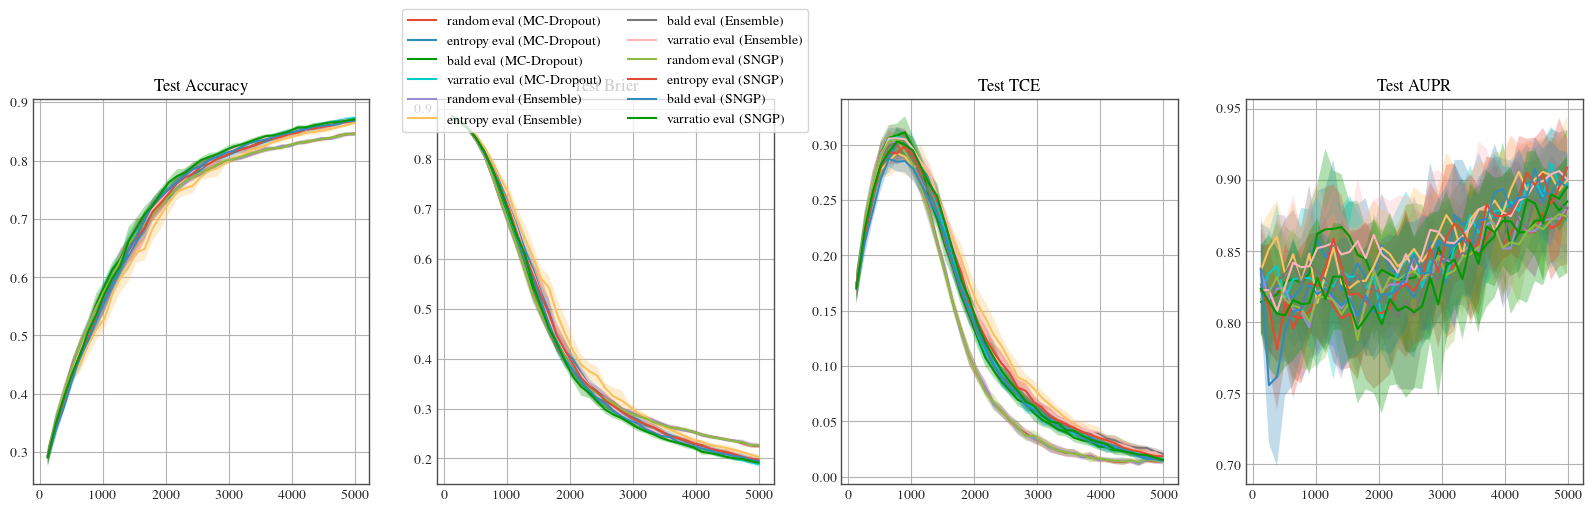

In [27]:
table_dict = {}
plt.figure(figsize=(20, 5))
show_std = True
for strat_name, results in tqdm(all_results.items()):

    test_accs = []
    test_nll = []
    test_brier = []
    test_tce = []
    test_ace = []
    test_aupr_cifar100 = []
    test_aupr_svhn = []
    n_labeled_samples = []
    for seed_result in results:
        data = seed_result['results']

        # Get metric values of interest
        n_labeled_samples.append([data[cycle]['n_labeled_samples'] for cycle in data])
        test_accs.append([data[cycle]['test_stats']['accuracy'] for cycle in data])
        test_nll.append([data[cycle]['test_stats']['nll'] for cycle in data])
        test_brier.append([data[cycle]['test_stats']['brier'] for cycle in data])
        test_tce.append([data[cycle]['test_stats']['tce'] for cycle in data])
        test_ace.append([data[cycle]['test_stats']['ace'] for cycle in data])
        test_aupr_cifar100.append([data[cycle]['test_stats'].get('aupr_CIFAR100', np.nan) for cycle in data])
        test_aupr_svhn.append([data[cycle]['test_stats'].get('aupr_SVHN', np.nan) for cycle in data])

    n_labeled_samples = np.mean(n_labeled_samples, 0)
    test_accs_mean, test_accs_std = np.mean(test_accs, 0), np.std(test_accs, 0)
    test_nll_mean, test_nll_std = np.mean(test_nll, 0), np.std(test_nll, 0)
    test_brier_mean, test_brier_std = np.mean(test_brier, 0), np.std(test_brier, 0)
    test_tce_mean, test_tce_std = np.mean(test_tce, 0), np.std(test_tce, 0)
    test_ace_mean, test_ace_std = np.mean(test_ace, 0), np.std(test_ace, 0)
    test_aupr_svhn_mean, test_aupr_svhn_std = np.mean(test_aupr_svhn, 0), np.std(test_aupr_svhn, 0)
    test_aupr_cifar100_mean, test_aupr_cifar100_std = np.mean(test_aupr_cifar100, 0), np.std(test_aupr_cifar100, 0)

    table_dict[strat_name] = {
        'acc (Final)': test_accs_mean[-1], 
        'acc (AUC)': np.mean(test_accs_mean), 
        'brier (Final)': test_brier_mean[-1], 
        'brier (AUC)': np.mean(test_brier_mean), 
        'TCE (Final)': test_tce_mean[-1], 
        'TCE (AUC)': np.mean(test_tce_mean), 
        'ACE (Final)': test_ace_mean[-1], 
        'ACE (AUC)': np.mean(test_ace_mean), 
        'AUPR CIFAR100 (Final)': test_aupr_cifar100_mean[-1],
        'AUPR CIFAR100 (AUC)': np.mean(test_aupr_cifar100_mean),
        'AUPR SVHN (Final)': test_aupr_svhn_mean[-1],
        'AUPR SVHN (AUC)': np.mean(test_aupr_svhn_mean),
    }

    plt.subplot(141)
    plt.title('Test Accuracy')
    plt.plot(n_labeled_samples, test_accs_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean+test_accs_std, alpha=.3)
    plt.subplot(142)
    plt.title('Test Brier')
    plt.plot(n_labeled_samples, test_brier_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_brier_mean-test_brier_std, test_brier_mean+test_brier_std, alpha=.3)
    plt.subplot(143)
    plt.title('Test TCE')
    plt.plot(n_labeled_samples, test_tce_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_tce_mean-test_tce_std, test_tce_mean+test_tce_std, alpha=.3)
    plt.subplot(144)
    plt.title('Test AUPR')
    plt.plot(n_labeled_samples, test_aupr_svhn_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_aupr_svhn_mean-test_aupr_svhn_std, test_aupr_svhn_mean+test_aupr_svhn_std, alpha=.3)
    # plt.plot(n_labeled_samples, test_aupr_svhn_mean, '-', label=strat_name)
    # plt.fill_between(n_labeled_samples, test_aupr_svhn_mean-test_aupr_svhn_std, test_aupr_svhn_mean+test_aupr_svhn_std, alpha=.3)

    # plt.subplot(144)
    # plt.title('Train Loss')
    # plt.plot(n_labeled_samples, train_loss_mean, '-', label=strat_name)
    # plt.fill_between(n_labeled_samples, train_loss_mean-train_loss_std, train_loss_mean+train_loss_std, alpha=.3)

plt.subplot(142).legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)
        

In [28]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict)
print(df.T.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & acc (Final) & acc (AUC) & brier (Final) & brier (AUC) & TCE (Final) & TCE (AUC) & ACE (Final) & ACE (AUC) & AUPR CIFAR100 (Final) & AUPR CIFAR100 (AUC) & AUPR SVHN (Final) & AUPR SVHN (AUC) \\
\midrule
random eval (MC-Dropout) & 0.847 & 0.711 & 0.225 & 0.425 & 0.014 & 0.107 & 0.022 & 0.038 & 0.761 & 0.703 & 0.880 & 0.837 \\
entropy eval (MC-Dropout) & 0.869 & 0.715 & 0.196 & 0.426 & 0.017 & 0.127 & 0.023 & 0.041 & 0.784 & 0.714 & 0.897 & 0.854 \\
bald eval (MC-Dropout) & 0.871 & 0.722 & 0.193 & 0.415 & 0.016 & 0.123 & 0.022 & 0.039 & 0.782 & 0.711 & 0.885 & 0.849 \\
varratio eval (MC-Dropout) & 0.873 & 0.722 & 0.189 & 0.418 & 0.017 & 0.126 & 0.022 & 0.040 & 0.786 & 0.716 & 0.898 & 0.850 \\
random eval (Ensemble) & 0.845 & 0.710 & 0.226 & 0.426 & 0.014 & 0.107 & 0.022 & 0.038 & 0.758 & 0.703 & 0.881 & 0.838 \\
entropy eval (Ensemble) & 0.865 & 0.703 & 0.203 & 0.442 & 0.018 & 0.134 & 0.023 & 0.042 & 0.782 & 0.711 & 0.900 & 0.860 \\
bald eval (En

In [29]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict)
print(df.T[['brier (AUC)', 'TCE (AUC)', 'AUPR CIFAR100 (AUC)', 'AUPR SVHN (AUC)']].to_latex(float_format="%.3f"))

\begin{tabular}{lrrrr}
\toprule
 & brier (AUC) & TCE (AUC) & AUPR CIFAR100 (AUC) & AUPR SVHN (AUC) \\
\midrule
random eval (MC-Dropout) & 0.425 & 0.107 & 0.703 & 0.837 \\
entropy eval (MC-Dropout) & 0.426 & 0.127 & 0.714 & 0.854 \\
bald eval (MC-Dropout) & 0.415 & 0.123 & 0.711 & 0.849 \\
varratio eval (MC-Dropout) & 0.418 & 0.126 & 0.716 & 0.850 \\
random eval (Ensemble) & 0.426 & 0.107 & 0.703 & 0.838 \\
entropy eval (Ensemble) & 0.442 & 0.134 & 0.711 & 0.860 \\
bald eval (Ensemble) & 0.418 & 0.126 & 0.710 & 0.843 \\
varratio eval (Ensemble) & 0.422 & 0.132 & 0.716 & 0.859 \\
random eval (SNGP) & 0.425 & 0.107 & 0.703 & 0.837 \\
entropy eval (SNGP) & 0.424 & 0.129 & 0.713 & 0.846 \\
bald eval (SNGP) & 0.417 & 0.121 & 0.712 & 0.843 \\
varratio eval (SNGP) & 0.413 & 0.127 & 0.718 & 0.835 \\
\bottomrule
\end{tabular}



In [30]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict)
print(df.T[['acc (Final)', 'acc (AUC)']].T.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
 & random eval (MC-Dropout) & entropy eval (MC-Dropout) & bald eval (MC-Dropout) & varratio eval (MC-Dropout) & random eval (Ensemble) & entropy eval (Ensemble) & bald eval (Ensemble) & varratio eval (Ensemble) & random eval (SNGP) & entropy eval (SNGP) & bald eval (SNGP) & varratio eval (SNGP) \\
\midrule
acc (Final) & 0.847 & 0.869 & 0.871 & 0.873 & 0.845 & 0.865 & 0.871 & 0.869 & 0.845 & 0.868 & 0.868 & 0.871 \\
acc (AUC) & 0.711 & 0.715 & 0.722 & 0.722 & 0.710 & 0.703 & 0.721 & 0.720 & 0.711 & 0.716 & 0.718 & 0.724 \\
\bottomrule
\end{tabular}



In [31]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict)
print(df.T[['brier (Final)', 'TCE (Final)', 'ACE (Final)']].to_latex(float_format="%.3f"))
# print(df.T[['brier (Final)', 'TCE (Final)', 'AUPR CIFAR100 (Final)', 'AUPR SVHN (Final)']].to_latex(float_format="%.3f"))

\begin{tabular}{lrrr}
\toprule
 & brier (Final) & TCE (Final) & ACE (Final) \\
\midrule
random eval (MC-Dropout) & 0.225 & 0.014 & 0.022 \\
entropy eval (MC-Dropout) & 0.196 & 0.017 & 0.023 \\
bald eval (MC-Dropout) & 0.193 & 0.016 & 0.022 \\
varratio eval (MC-Dropout) & 0.189 & 0.017 & 0.022 \\
random eval (Ensemble) & 0.226 & 0.014 & 0.022 \\
entropy eval (Ensemble) & 0.203 & 0.018 & 0.023 \\
bald eval (Ensemble) & 0.194 & 0.021 & 0.022 \\
varratio eval (Ensemble) & 0.195 & 0.018 & 0.023 \\
random eval (SNGP) & 0.226 & 0.014 & 0.022 \\
entropy eval (SNGP) & 0.197 & 0.018 & 0.022 \\
bald eval (SNGP) & 0.195 & 0.014 & 0.021 \\
varratio eval (SNGP) & 0.192 & 0.015 & 0.021 \\
\bottomrule
\end{tabular}



In [32]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict)
print(df.T[['AUPR CIFAR100 (Final)', 'AUPR SVHN (Final)']].to_latex(float_format="%.3f"))
# print(df.T[['brier (Final)', 'TCE (Final)', 'AUPR CIFAR100 (Final)', 'AUPR SVHN (Final)']].to_latex(float_format="%.3f"))

\begin{tabular}{lrr}
\toprule
 & AUPR CIFAR100 (Final) & AUPR SVHN (Final) \\
\midrule
random eval (MC-Dropout) & 0.761 & 0.880 \\
entropy eval (MC-Dropout) & 0.784 & 0.897 \\
bald eval (MC-Dropout) & 0.782 & 0.885 \\
varratio eval (MC-Dropout) & 0.786 & 0.898 \\
random eval (Ensemble) & 0.758 & 0.881 \\
entropy eval (Ensemble) & 0.782 & 0.900 \\
bald eval (Ensemble) & 0.778 & 0.880 \\
varratio eval (Ensemble) & 0.786 & 0.901 \\
random eval (SNGP) & 0.759 & 0.874 \\
entropy eval (SNGP) & 0.784 & 0.909 \\
bald eval (SNGP) & 0.786 & 0.895 \\
varratio eval (SNGP) & 0.788 & 0.895 \\
\bottomrule
\end{tabular}



## Load Experiment

In [123]:
import sys
sys.path.append('..')
from active_learning import build_datasets, build_model

model_name = 'resnet18_mcdropout'
strat_name = 'random'
exp_path = Path(f'results/active_learning/CIFAR10/{model_name}/{strat_name}/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/seed1')
checkpoint = torch.load(exp_path / 'checkpoint.pth')
args =  OmegaConf.load(exp_path / '.hydra' / 'config.yaml')

trainer = build_model(args, n_classes=10)
model = trainer.model
model.load_state_dict(checkpoint['model'])

args.dataset_path = '/datasets'
_, _, test_ds, _ = build_datasets(args)

FileNotFoundError: [Errno 2] No such file or directory: 'results/active_learning/CIFAR10/resnet18_mcdropout/random/N_INIT100__ACQ_SIZE100__N_ACQ19/seed1/checkpoint.pth'

In [ ]:
results = load_json(exp_path / 'results.json')
results['cycle19']['test_stats']

{'test_acc1': 72.94999694824219,
 'test_loss': 0.9619036912918091,
 'test_nll': 0.8499259948730469,
 'test_brier': 0.38014087080955505,
 'test_tce': 0.06486481428146362,
 'test_mce': 0.036187052726745605,
 'test_CIFAR100_auroc': 0.7402122050000001,
 'test_CIFAR100_aupr': 0.6967468314841072,
 'test_SVHN_auroc': 0.7186415776736323,
 'test_SVHN_aupr': 0.8092618874912202}

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)

logits_list = []
targets_list = []
model.cuda()
model.eval()
for inputs, targets in test_loader:
    with torch.no_grad():
        logits = model(inputs.cuda())
    logits_list.append(logits.cpu())
    targets_list.append(targets.cpu())

logits = torch.cat(logits_list)
targets = torch.cat(targets_list)

AttributeError: 'DropoutResNet18' object has no attribute 'forward_sample'

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)
probas = model.get_probas(test_loader, device='cuda').mean(1)
logits = probas.log()

In [ ]:
from dal_toolbox.metrics.calibration import ExpectedCalibrationError, TopLabelCalibrationError, AdaptiveCalibrationError
from torchmetrics.classification import Accuracy

acc_fn = Accuracy()
print('Accuracy: {}'.format(acc_fn(logits, targets)))
tce_fn = TopLabelCalibrationError(n_bins=15)
print('ECE: {}'.format(tce_fn(logits.softmax(-1), targets)))
ace_fn = AdaptiveCalibrationError()
print('ACE: {}'.format(ace_fn(logits.softmax(-1), targets)))
plt.figure(figsize=(5, 5))
plt.plot(tce_fn.results['confs'], tce_fn.results['accs'], '-o', linewidth=2)
plt.plot([0, 1], [0, 1], linewidth=3, linestyle=':')
plt.twinx()
plt.grid()
bar_x = [conf for conf in tce_fn.results['confs'] if not np.isnan(conf)]
bar_y = [n for n in tce_fn.results['n_samples'] if n != 0]
plt.bar(bar_x, bar_y, width=.05, alpha=.3)
plt.tight_layout()
plt.savefig(f'plots_al/cal-plot_{model_name}_{strat_name}.pdf')
plt.show()

ValueError: The `preds` and `target` should have the same first dimension.

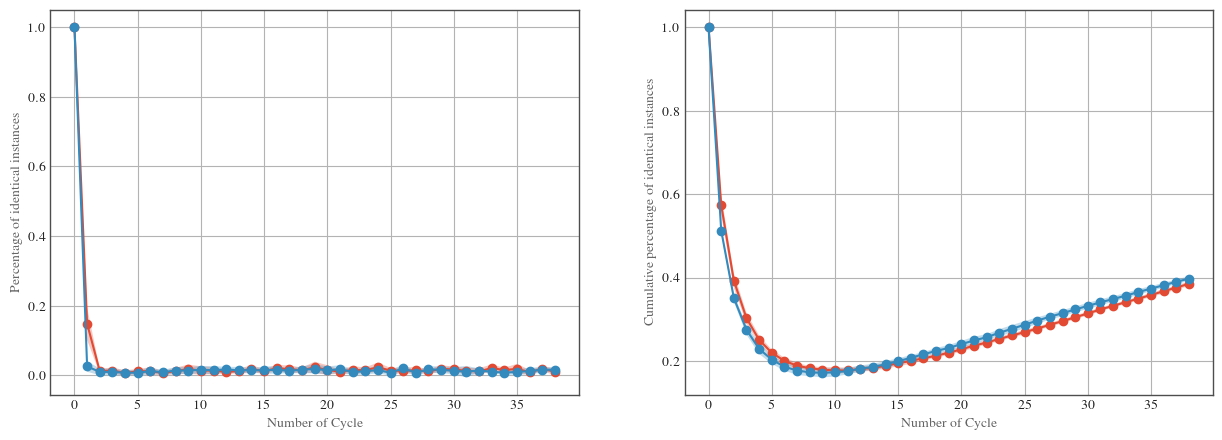

In [71]:
plt.figure(figsize=(15, 5))

for method in ['ls', 'mixup']:

    buy_agreement_list = []
    cum_buy_agreement_list = []

    for i_seed in range(1, 11):
        dir1 = experiments['entropy eval']
        json1 = dir1 / f'seed{i_seed}' / 'queried_indices.json'
        queried_indices1 = load_json(json1)

        dir2 = experiments[f'entropy ({method})']
        json2 = dir2 / f'seed{i_seed}' / 'queried_indices.json'
        queried_indices2 = load_json(json2)

        indices1 = []
        indices2 = []

        buy_agreement = []
        cumulative_buy_agreement = []

        for key in queried_indices1:
            q_indices1 = queried_indices1[key]
            q_indices2 = queried_indices2[key]
            indices1.extend(q_indices1)
            indices2.extend(q_indices2)

            buy_agreement.append(np.isin(q_indices1, q_indices2).mean())
            cumulative_buy_agreement.append((np.isin(indices1, indices2).mean()))

        buy_agreement_list.append(buy_agreement)
        cum_buy_agreement_list.append(cumulative_buy_agreement)

    buy_agreement_mean = np.mean(buy_agreement_list, axis=0)
    buy_agreement_std = np.std(buy_agreement_list, axis=0)
    cum_buy_agreement_mean = np.mean(cum_buy_agreement_list, axis=0)
    cum_buy_agreement_std = np.std(cum_buy_agreement_list, axis=0)

    plt.subplot(121)
    plt.plot(buy_agreement_mean, '-o')
    plt.fill_between(range(len(buy_agreement_mean)), buy_agreement_mean+buy_agreement_std, buy_agreement_mean-buy_agreement_std, alpha=.3)
    plt.xlabel('Number of Cycle')
    plt.ylabel('Percentage of identical instances')

    plt.subplot(122)
    plt.plot(cum_buy_agreement_mean, '-o')

    plt.fill_between(range(len(cum_buy_agreement_mean)), cum_buy_agreement_mean+cum_buy_agreement_std, cum_buy_agreement_mean-cum_buy_agreement_std, alpha=.3)
    plt.xlabel('Number of Cycle')
    plt.ylabel('Cumulative percentage of identical instances')

plt.show()

In [60]:
buy_agreement_list[0]
buy_agreement_list[1]

[1.0,
 0.03125,
 0.0,
 0.015625,
 0.0,
 0.0234375,
 0.0,
 0.0078125,
 0.015625,
 0.0,
 0.0234375,
 0.0390625,
 0.015625,
 0.0234375,
 0.015625,
 0.0390625,
 0.0234375,
 0.0078125,
 0.03125,
 0.03125,
 0.0390625,
 0.015625,
 0.015625,
 0.015625,
 0.0078125,
 0.0,
 0.0078125,
 0.015625,
 0.015625,
 0.0234375,
 0.015625,
 0.0234375,
 0.0234375,
 0.015625,
 0.0,
 0.015625,
 0.015625,
 0.015625,
 0.015625]

10


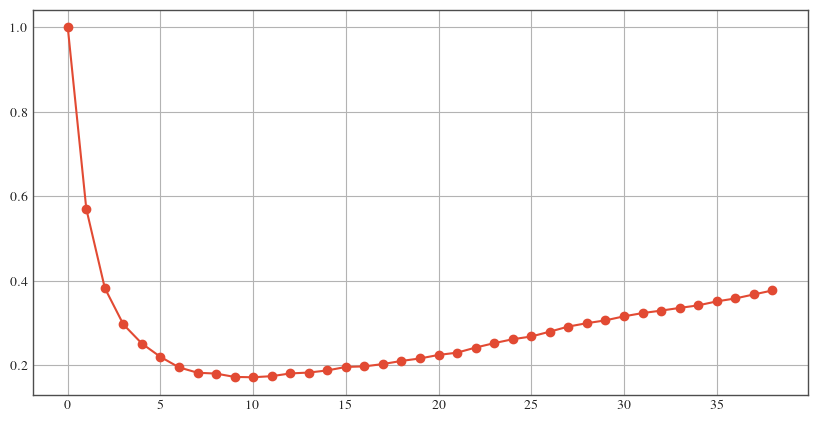

In [97]:
print(i_seed)
dir1 = experiments['entropy eval']
json1 = dir1 / f'seed{i_seed}' / 'results.json'
results1 = load_json(json1)

dir2 = experiments['entropy (ls) eval']
json2 = dir2 / f'seed{i_seed}' / 'results.json'
results2 = load_json(json2)

cum_buy_agreement = []
for key in results1:
    cum_buy_agreement.append(np.isin(results1[key]['labeled_indices'], results2[key]['labeled_indices']).mean())
plt.plot(cum_buy_agreement, '-o')

10


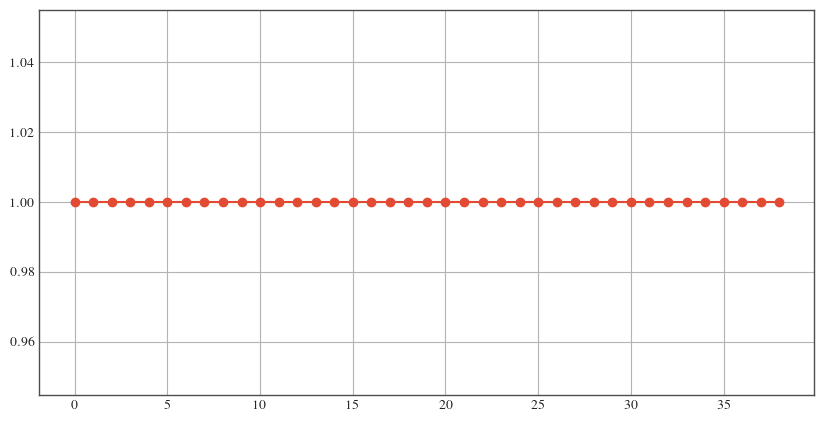

In [98]:
print(i_seed)
dir1 = experiments['entropy (ls)']
json1 = dir1 / f'seed{i_seed}' / 'queried_indices.json'
queried_indices1 = load_json(json1)

dir2 = experiments['entropy (ls) eval']
json2 = dir2 / f'seed{i_seed}' / 'results.json'
results2 = load_json(json2)

cum_buy_agreement = []
for key in results1:
    cum_buy_agreement.append(np.isin(queried_indices1[key], results2[key]['labeled_indices']).mean())
plt.plot(cum_buy_agreement, '-o')

In [115]:
from dal_toolbox.metrics import TopLabelCalibrationPlot

probas = np.random.rand(100, 2)
probas = probas / probas.sum(-1, keepdims=True)
labels = np.random.randint(0, 2, size=(100,))

probas = torch.from_numpy(probas).float()
labels = torch.from_numpy(labels).long()

tce_plot = TopLabelCalibrationPlot()
results = tce_plot(probas, labels)
confs = results['confs']
accs = results['accs']
n_samples = results['n_samples']

np.nansum(n_samples / n_samples.sum() * confs * np.maximum(confs - accs, 0)) 

0.21480516

tensor([   nan,    nan,    nan,    nan,    nan,    nan,    nan, 0.0140, 0.0207,
        0.0092, 0.0133, 0.0229, 0.0029, 0.0292, 0.0087])